# SkimLit

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Get data

This is a replication of the paper PubMed 200k RCT, download the dataset they used.The data set is available on [github](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are there in PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start our experiment using the 20k dataset with numbers replaced by '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

Now that we've got our data, let's write a function to read in all of the lines of a target text file.

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as list.

  Args:
    filename: a string containing the target filepath
  
  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [7]:
# Read in the training text
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

This is how we should make our to be (give it some structure)

```
[{'line_number' : 0,
  'target' : 'BACKGROUNG',
  'text' : 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines' : 11},
  ...]
```

In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data

  Takes in filename, reads it's contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many lines are there in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # Get all lines from the filename
  abstract_lines = '' # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith('###'): # check to see if it's the start of an abstract
      abstract_id = line
      abstract_lines = '' # reset the abstract string if the line belongs to new abstract
    elif line.isspace(): # check to see if it's new line
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstractand count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line
  
  return abstract_samples

In [9]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [10]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that we have the data in a more structured format, let's visualize the data using a DataFrame

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

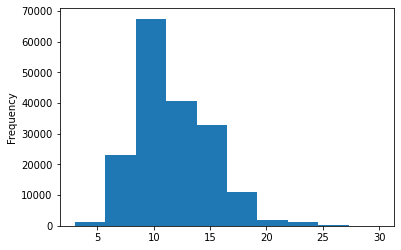

In [14]:
# Check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


In [16]:
# View 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numerical labels

In [17]:
# One hot encode the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encoding

In [18]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and  number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-09 15:45:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-09 15:45:14 (88.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) fro deep sequence models

Before we start buliding deeper models, we've got to create vectorization and embedding layers.

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

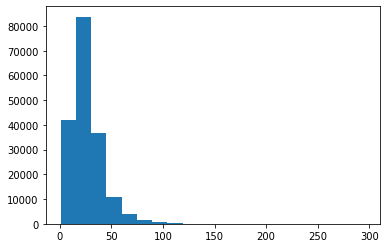

In [27]:
# What does the distribution of the length of the sentences look like?
plt.hist(sent_lens, bins=20);

In [28]:
# How long is sentence in 95th percentile?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorization layer

We want to make a layer that maps our texts from words to numbers

In [29]:
# Vocab size (from paper)
max_tokens = 68000

In [30]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out the text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
completeness of resection was significantly higher in pdt arm ( r@-@ % , r@-@ % ) vs. no-pdt arm ( r@-@ % , r@-@ % ) , p = @ .

Length of text: 31

Vectorized text: [[ 8119     4   814    10    39    82     5  2342   207   491   491    44
  22366   207   491   491    14     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [33]:
# How many words in our vocabulary
rtc_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocab: {len(rtc_20k_text_vocab)}')
print(f'Most common words: {rtc_20k_text_vocab[:5]}')
print(f'Least common words: {rtc_20k_text_vocab[-5:]}')

Number of words in the vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create custom text embedding

In [34]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rtc_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

In [35]:
# Example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization:\n {vectorized_sentence}')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Shape of embedded sentence:\n {embedded_sentence.shape}')

Sentence before vectorization:
 completeness of resection was significantly higher in pdt arm ( r@-@ % , r@-@ % ) vs. no-pdt arm ( r@-@ % , r@-@ % ) , p = @ .

Sentence after vectorization:
 [[ 8119     4   814    10    39    82     5  2342   207   491   491    44
  22366   207   491   491    14     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[-0.03909886  0.04887091  0.04396952 ... -0.0243499   0.03334835
   -0.00856461]
  [-0.0207916  -0.04109214 -0.02170099 ... -0.01022296  0.01652974
    0.0052309 ]
  [-0.04542247 -0.04083509 -0.02077364 ...  0.01254655  0.03471505
   -0.04087535]
  ...
  [-0.04017959 -0.04777696 -0.01463413 ... -0.04017379 -0.01750029
    0.03305518]
  [-0.04017959 -0.04777696 -0.01463413 ... -0.04017379 -0.01750029
    0.03305518]
  [-0.04017959 -0.0

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup up our data to run as fast as possible with the TensorFlow tf.data.API

In [36]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Take the TensorSliceDatasets and turn them intp prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [38]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu') (token_embeddings)
x = layers.GlobalAveragePooling1D() (x)
outputs = layers.Dense(num_classes, activation='softmax') (x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.9298 - accuracy: 0.6279 - val_loss: 0.6900 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6554 - accuracy: 0.7578 - val_loss: 0.6251 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6123 - accuracy: 0.7780 - val_loss: 0.5913 - val_accuracy: 0.7876


In [40]:
# Evaluate in whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5933 - accuracy: 0.7874


[0.593285083770752, 0.787402331829071]

In [41]:
# Make predictions 
model_1_pred_probs = model_1.predict(val_dataset)

In [42]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [43]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74023566794651,
 'precision': 0.7844273111956995,
 'recall': 0.7874023566794651,
 'f1': 0.7850521925297935}

In [44]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically [the universal sentence encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

The paper originally usese GloVe embeddings, however we're going to stick with the later created USE pretrained embeddings.

In [45]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [46]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random Sentence:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding: \n {use_embedded_sentence[0][:30]}\n')
print(f'Lenght of sentence embedding: {len(use_embedded_sentence[0])}')

Random Sentence:
 additionally , the aim is to test whether vr benefits dental patients with all levels of dental anxiety or whether it could be especially beneficial for patients suffering from higher levels of dental anxiety .
Sentence after embedding: 
 [ 0.01599268 -0.05478711 -0.05385172  0.01055385 -0.00185283  0.00991269
 -0.04488528 -0.0243578   0.04364168 -0.06410925  0.0756696   0.01948726
  0.06553569  0.05717786 -0.05696671 -0.03964784 -0.07582626 -0.06098059
 -0.0221548   0.00693031  0.07309812  0.0656529   0.04277153  0.05277742
 -0.06897441  0.03604424 -0.01862633 -0.0617856   0.06429365  0.00305091]

Lenght of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [47]:
# Define feature extraction model using TF hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [48]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.2 * len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.2 * len(val_dataset)))

Epoch 1/3
1125/1125 [==============================] - 16s 13ms/step - loss: 0.8416 - accuracy: 0.6757 - val_loss: 0.7536 - val_accuracy: 0.7075
Epoch 2/3
1125/1125 [==============================] - 14s 12ms/step - loss: 0.7340 - accuracy: 0.7196 - val_loss: 0.7132 - val_accuracy: 0.7259
Epoch 3/3
1125/1125 [==============================] - 14s 12ms/step - loss: 0.7208 - accuracy: 0.7244 - val_loss: 0.6810 - val_accuracy: 0.7397


In [50]:
# Evaluate on the whole validation dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.6849 - accuracy: 0.7381


[0.6849493980407715, 0.7380511164665222]

In [51]:
# Make preditions with feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)

In [52]:
# Convert the predictions to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [53]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.80511055209851,
 'precision': 0.7331491197697674,
 'recall': 0.7380511055209851,
 'f1': 0.7341230794274854}

## Model 3: Conv1D with charecter embeddings

The paper that we're replicating states that they used a combination of taken and charecter-level embeddings.

Previously we've usesd token-level embeddings but we'll need to do similar steps for charecters if we want to use char-level embeddings.

In [54]:
# Make function to split sentences into charecters
def split_chars(text):
  return ' '.join(list(text))

In [55]:
# Split sequence-levl data splits into charecter-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [56]:
# What's the average charecter length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

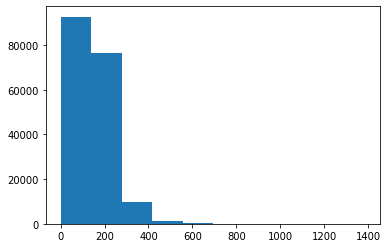

In [57]:
# Check the distribution of lens of chars in a sentence
plt.hist(char_lens);

In [58]:
# Find what charecter length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [59]:
# Get all keyboard charecters
import string
allkeys = string.ascii_lowercase + string.digits

In [60]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(allkeys) + 2 # add 2 for space and OOV (out of vocab) aka UKN
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [61]:
# Adapt charecter vectorizer to training charecter
char_vectorizer.adapt(train_chars)

In [62]:
# Check charecter voacb specs
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different charecters in charecter vocab: {len(char_vocab)}')
print(f'5 most common charecters: {char_vocab[:5]}')
print(f'5 least common charecters: {char_vocab[-5:]}')

Number of different charecters in charecter vocab: 28
5 most common charecters: ['', '[UNK]', 'e', 't', 'i']
5 least common charecters: ['k', 'x', 'z', 'q', 'j']


In [63]:
# Test our charecter vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'Length of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized char - {len(vectorized_chars[0])}')

Charified text:
 t h e r e   w e r e   n o   s t a t i s t i c a l l y   s i g n i f i c a n t   d i f f e r e n c e s   i n   a m b u l a t o r y   a b i l i t y   ,   p o s s i b i l i t y   t o   r e t u r n   h o m e   m o r t a l i t y   o r   e a r l y   r a d i o l o g i c a l   a c e t a b u l a r   e r o s i o n   .
Length of random_train_chars: 135

Vectorized chars:
 [[ 3 13  2  8  2 20  2  8  2  6  7  9  3  5  3  4  9  3  4 11  5 12 12 19
   9  4 18  6  4 17  4 11  5  6  3 10  4 17 17  2  8  2  6 11  2  9  4  6
   5 15 22 16 12  5  3  7  8 19  5 22  4 12  4  3 19 14  7  9  9  4 22  4
  12  4  3 19  3  7  8  2  3 16  8  6 13  7 15  2 15  7  8  3  5 12  4  3
  19  7  8  2  5  8 12 19  8  5 10  4  7 12  7 18  4 11  5 12  5 11  2  3
   5 22 16 12  5  8  2  8  7  9  4  7  6  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  

## Creating charecter-level embedding

In [64]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name='char_embedding_layer')

In [65]:
# Text our charecter embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer(random_train_chars))
print(f'Embedded chars {char_embed_example}')
print(f'\nCharecter embedding shape: {char_embed_example.shape}')

Charified text:
 t h e r e   w e r e   n o   s t a t i s t i c a l l y   s i g n i f i c a n t   d i f f e r e n c e s   i n   a m b u l a t o r y   a b i l i t y   ,   p o s s i b i l i t y   t o   r e t u r n   h o m e   m o r t a l i t y   o r   e a r l y   r a d i o l o g i c a l   a c e t a b u l a r   e r o s i o n   .

Embedded chars [[ 0.02211371  0.02864799 -0.01709957 ...  0.04164864 -0.01993489
  -0.01712783]
 [-0.00653636  0.0149267  -0.02064385 ...  0.02292515 -0.04850109
   0.00665094]
 [-0.00217284  0.01975895 -0.03772251 ... -0.02683628  0.04049153
   0.02097868]
 ...
 [ 0.00997584 -0.01084129  0.00871251 ...  0.01331897  0.00234927
   0.00903556]
 [ 0.00997584 -0.01084129  0.00871251 ...  0.01331897  0.00234927
   0.00903556]
 [ 0.00997584 -0.01084129  0.00871251 ...  0.01331897  0.00234927
   0.00903556]]

Charecter embedding shape: (290, 25)


## Building a Conv1D model to fit on charecter embeddings

In [66]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1, ), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu') (char_embeddings)
x = layers.GlobalMaxPooling1D() (x)
outputs = layers.Dense(num_classes, activation='softmax') (x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_3_conv1d_char_embeddings')

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [67]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding_layer (Embed  (None, 290, 25)          700       
 ding)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                    

In [68]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [69]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.2 * len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.2 * len(val_char_dataset)))

Epoch 1/3
1125/1125 [==============================] - 7s 5ms/step - loss: 1.1389 - accuracy: 0.5458 - val_loss: 0.9424 - val_accuracy: 0.6298
Epoch 2/3
1125/1125 [==============================] - 6s 5ms/step - loss: 0.9036 - accuracy: 0.6444 - val_loss: 0.8398 - val_accuracy: 0.6749
Epoch 3/3
1125/1125 [==============================] - 6s 5ms/step - loss: 0.8484 - accuracy: 0.6698 - val_loss: 0.7884 - val_accuracy: 0.6966


In [70]:
# Make predictions with charecter model only
model_3_pred_probs = model_3.predict(val_char_dataset)

In [71]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

In [72]:
# Calculate results for Conv1D model chars only 
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 69.23076923076923,
 'precision': 0.6798072060884297,
 'recall': 0.6923076923076923,
 'f1': 0.6817594371750364}

## Model 4: Combining pretrained token embeddings + charecter embeddings (hybrid embedding layer)

> 1. Create a token-level embedding model (similar to `model_1`)
> 2. Create a charecter-level model (similar to `model_3` with a slight modification)
> 3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
> 4. Build a series of output layers on top of layer 3
> 5. Construct a model that takes token and charecter-level sequences as input and produces sequence label probabilities as output.

In [88]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [89]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

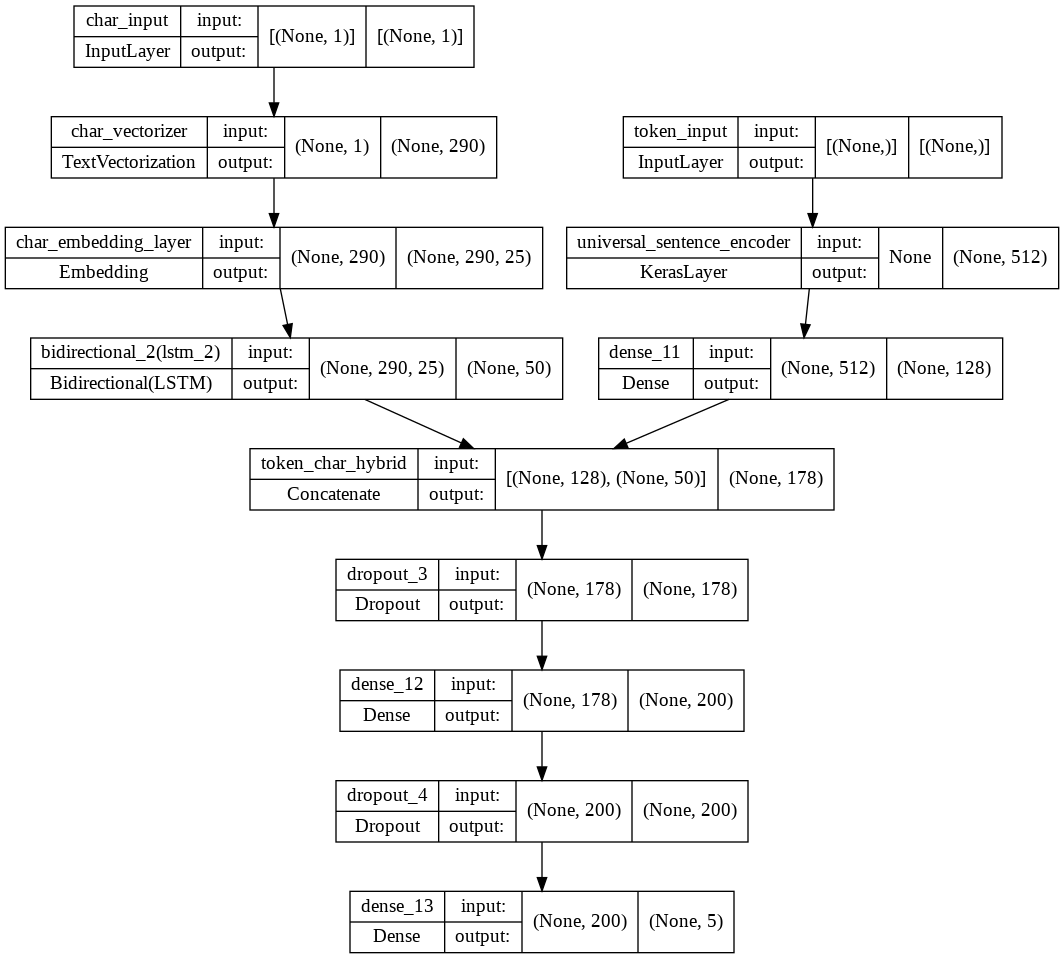

In [90]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [91]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and charecter data into a tf.data Dataset

In [92]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Fitting a model on token and char-level sequences

In [93]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 55ms/step - loss: 0.9631 - accuracy: 0.6132 - val_loss: 0.7693 - val_accuracy: 0.7058
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.7882 - accuracy: 0.6944 - val_loss: 0.7139 - val_accuracy: 0.7304
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7618 - accuracy: 0.7099 - val_loss: 0.6865 - val_accuracy: 0.7404


In [94]:
# Evaluate one the whole validation daataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.6933 - accuracy: 0.7374


[0.6932687163352966, 0.7373560070991516]

In [95]:
# Make predictions using the token-charecter model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)

In [96]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [97]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.73560174764994,
 'precision': 0.7366965178951171,
 'recall': 0.7373560174764994,
 'f1': 0.7355806796863927}

## Model 5: Transfer Learning with pretrained token embeddings + charecter embeddings + positional embeddings

In [98]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [100]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

(array([4.5000e+04, 4.4941e+04, 4.2383e+04, 2.9914e+04, 1.2840e+04,
        3.8000e+03, 9.1000e+02, 2.0000e+02, 4.3000e+01, 9.0000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

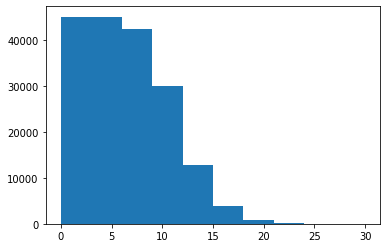

In [101]:
# Check the distribution of 'line_number' column
plt.hist(train_df['line_number']);

In [103]:
# Use TensorFlow to create one-hot-emcoded tensors of our 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now that we've encoded our line numbers feature, let's do the same for our total lines feature...

In [105]:
# How many different total lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

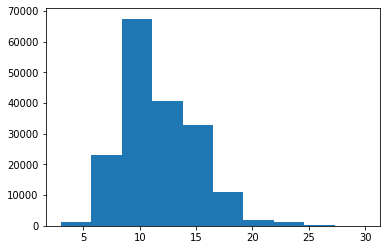

In [107]:
plt.hist(train_df['total_lines']);

In [108]:
# Use TensorFlow to create one-hot-encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

### Building a tribrid embedding model

1. Create a token-level model
2. Create a charecter-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines' feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into tf.keras.Model

In [143]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [144]:
# Get summary of model_5
model_5.summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

In [145]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding dataset using tf.data

In [146]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, Evaluating and making predictions with our tribrid model

In [147]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 88s 52ms/step - loss: 1.0931 - accuracy: 0.7265 - val_loss: 0.9774 - val_accuracy: 0.8075
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 0.9630 - accuracy: 0.8177 - val_loss: 0.9466 - val_accuracy: 0.8305
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9478 - accuracy: 0.8250 - val_loss: 0.9356 - val_accuracy: 0.8368


In [148]:
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.9338 - accuracy: 0.8372


[0.9338222146034241, 0.8372169733047485]

In [149]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)

In [152]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

In [154]:
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 83.72169998676023,
 'precision': 0.8360054149891019,
 'recall': 0.8372169998676022,
 'f1': 0.8360686011874319}

## Compare model results

In [156]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.740236,0.784427,0.787402,0.785052
pretrained_token_embed,73.805111,0.733149,0.738051,0.734123
custom_char_embed_conv1d,69.230769,0.679807,0.692308,0.681759
hybrid_char_token_embed,73.735602,0.736697,0.737356,0.735581
tribrid_pos_char_token_embed,83.721700,0.836005,0.837217,0.836069


In [157]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

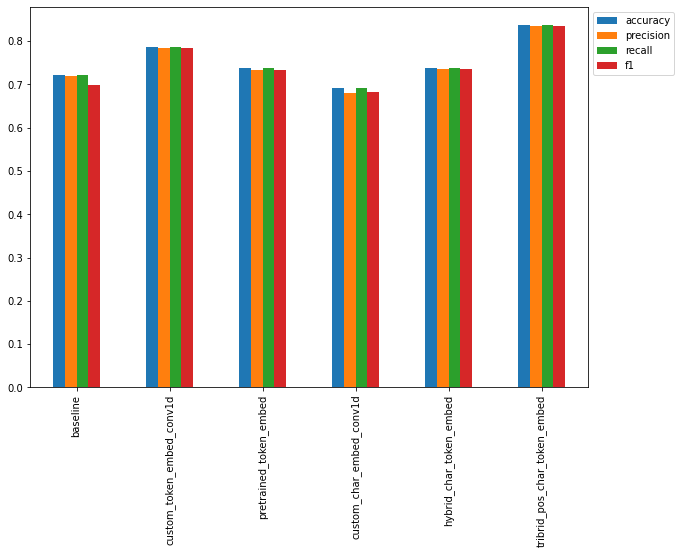

In [158]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

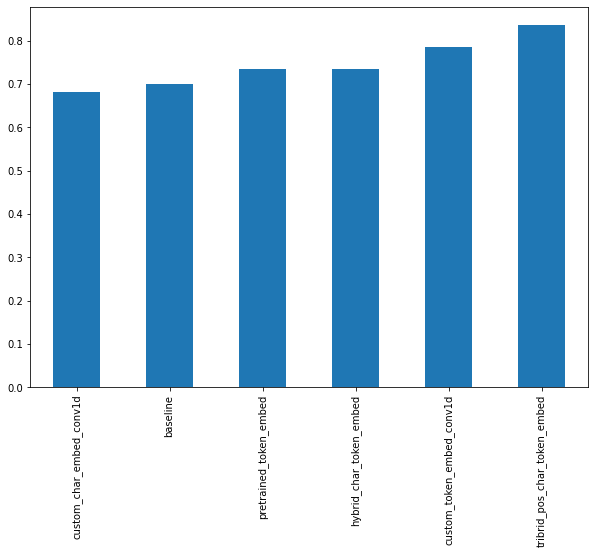

In [159]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=True) ['f1'].plot(kind='bar', figsize=(10, 7));

## Save and load best performing model

In [161]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") 